In [1]:
# Package set up
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib as matlib
import glob
import calendar
import regionmask
import cftime
import seaborn as sns

In [2]:
# Define seasonal rainfall periods for May-October Growing Season and bi-monthly sub-period
def is_GS(month):
    return (month >= 5) & (month <= 10)

def is_JA(month):
    return (month >= 7) & (month <= 8)

In [3]:
# Load observational mode file (CVDP) and get 5-year rolling means
cvdp_fname = '/glade/work/tanderson/CVDP/TAnderson_CVDP_combo_CMIP6gmt.nc'
dset_cvdp = xr.open_dataset(cvdp_fname, decode_times=False)

# Get correct time units
units, reference_date = dset_cvdp.time.attrs['units'].split('since')
dset_cvdp['time'] = pd.date_range(start=reference_date, periods=dset_cvdp.sizes['time'], freq='MS')
dset_cvdp = dset_cvdp.sel(time=slice('1920-01-01','2019-12-01')) # slice time of interest

#Sub-select years and months
dset_obs_year = dset_cvdp['time.year']
dset_obs_month = dset_cvdp['time.month']

# Load each mode
clljObs = dset_cvdp.clljV2_timeseries_mon
ninoObs = dset_cvdp.nino34
amoObs = dset_cvdp.amo_timeseries_mon
pdoObs = dset_cvdp.pdo_timeseries_mon
#print(clljObs)

# Get annual GS mean
GS_cllj_Obs = clljObs.sel(time=is_GS(clljObs['time.month']))
GS_cllj_Obs = GS_cllj_Obs.groupby('time.year').mean('time', keep_attrs=True) 

GS_nino_Obs = ninoObs.sel(time=is_GS(ninoObs['time.month']))
GS_nino_Obs = GS_nino_Obs.groupby('time.year').mean('time', keep_attrs=True) 

# Get annual JA mean
JA_cllj_Obs = clljObs.sel(time=is_JA(clljObs['time.month']))
JA_cllj_Obs = JA_cllj_Obs.groupby('time.year').mean('time', keep_attrs=True) 

JA_nino_Obs = ninoObs.sel(time=is_JA(ninoObs['time.month']))
JA_nino_Obs = JA_nino_Obs.groupby('time.year').mean('time', keep_attrs=True) 

# 5 year rolling means 
GS_5yr_clljObs = GS_cllj_Obs.rolling(year=5).mean()
GS_5yr_ninoObs = GS_nino_Obs.rolling(year=5).mean()

JA_5yr_clljObs = JA_cllj_Obs.rolling(year=5).mean()
JA_5yr_ninoObs = JA_nino_Obs.rolling(year=5).mean()

In [4]:
# Load in OLE mode values for all ensemble members
cvdpOLE_fname = '/glade/work/tanderson/obsLE/parameters_v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew/obs/synthetic_mode_ts.nc'
dset_cvdpOLE = xr.open_dataset(cvdpOLE_fname)

# Replace just month values with actual dates
dset_cvdpOLE['month'] = pd.date_range(start=reference_date, periods=dset_cvdp.sizes['time'], freq='MS')
dset_cvdpOLE = dset_cvdpOLE.rename({'month': 'time'})

# Load each mode
clljOLE = dset_cvdpOLE.CLLJ_surr
ninoOLE = dset_cvdpOLE.ENSO_surr

# Get annual GS mean
GS_cllj_OLE = clljOLE.sel(time=is_GS(clljOLE['time.month']))
GS_cllj_OLE = GS_cllj_OLE.groupby('time.year').mean('time', keep_attrs=True) 

GS_nino_OLE = ninoOLE.sel(time=is_GS(ninoOLE['time.month']))
GS_nino_OLE = GS_nino_OLE.groupby('time.year').mean('time', keep_attrs=True) 

JA_cllj_OLE = clljOLE.sel(time=is_JA(clljOLE['time.month']))
JA_cllj_OLE = JA_cllj_OLE.groupby('time.year').mean('time', keep_attrs=True) 

JA_nino_OLE = ninoOLE.sel(time=is_JA(ninoOLE['time.month']))
JA_nino_OLE = JA_nino_OLE.groupby('time.year').mean('time', keep_attrs=True) 

# 5 year rolling means 
GS_5yr_clljOLE = GS_cllj_OLE.rolling(year=5).mean()
GS_5yr_ninoOLE = GS_nino_OLE.rolling(year=5).mean()

JA_5yr_clljOLE = JA_cllj_OLE.rolling(year=5).mean()
JA_5yr_ninoOLE = JA_nino_OLE.rolling(year=5).mean()

In [5]:
# Find 5th percentile OLENS runs GS

# Load file for regional GS time series from OLE
gsOLEpr = pd.read_csv('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalGS-TS.csv', header=None)

# Take 5 year means
gsOLEpr5yr = gsOLEpr.rolling(window=5).mean()

# Convert to numpy
gsOLEpr5yrnp = gsOLEpr5yr.to_numpy()

# Unravel data
fifthOLEpr = gsOLEpr5yrnp.ravel()

# Find the 5th quantile value of OLE
fifthOLEprGS = np.nanquantile(fifthOLEpr,0.05)
print(fifthOLEprGS)

# Subselect values less than or equal to 5th percentile
fifthOLEprlog = fifthOLEpr<=fifthOLEprGS
print(len(fifthOLEprlog))

# Unravel values and select those that are TRUE
clljGSlong = GS_5yr_clljOLE.values.ravel()
ninoGSlong = GS_5yr_ninoOLE.values.ravel()

cllj5thGS = clljGSlong[fifthOLEprlog==True]
nino5thGS = ninoGSlong[fifthOLEprlog==True]
print(len(cllj5thGS))


1378.2609879870417
100000
4800


In [7]:
# Find 5th percentile OLENS runs JA

# Load file for regional JA time series from OLE
jaOLEpr = pd.read_csv('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-noF_CLLJV2_v02_CentAm_Pr_05deg_blockNew-regionalJA-TS.csv', header=None)

# Take 5 year means
jaOLEpr5yr = jaOLEpr.rolling(window=5).mean()

# Convert to numpy
jaOLEpr5yrnp = jaOLEpr5yr.to_numpy()

# Unravel data
fifthOLEpr = jaOLEpr5yrnp.ravel()

# Find the 5th quantile value of OLE
fifthOLEprJA = np.nanquantile(fifthOLEpr,0.05)
print(fifthOLEprJA)

# Subselect values less than or equal to 5th percentile
fifthOLEprlogJA = fifthOLEpr<=fifthOLEprJA
print(len(fifthOLEprlogJA))

# Unravel values and select those that are TRUE
clljJAlong = JA_5yr_clljOLE.values.ravel()
ninoJAlong = JA_5yr_ninoOLE.values.ravel()

cllj5thJA = clljJAlong[fifthOLEprlogJA==True]
nino5thJA = ninoJAlong[fifthOLEprlogJA==True]
print(len(cllj5thJA))

419.1767775467936
100000
4800


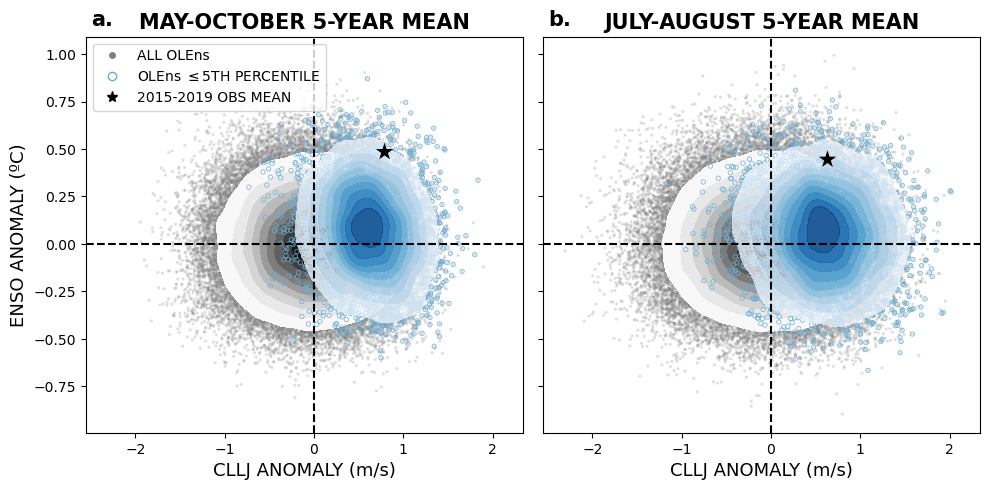

In [9]:
# JA & Growing season

#Blue color
from matplotlib.lines import Line2D
cmap = mpl.colormaps['Blues']
blu = cmap(0.5)

fig, axes = plt.subplots(1,2,figsize=(10, 5),sharey=True,sharex=True)
# Growing Season
# All values
sns.scatterplot(ax=axes[0],x=GS_5yr_clljOLE.values.ravel(), y=GS_5yr_ninoOLE.values.ravel(), s=5, color="grey" ,edgecolor = 'none', alpha=.25)
sns.kdeplot(ax=axes[0],x=GS_5yr_clljOLE.values.ravel(), y=GS_5yr_ninoOLE.values.ravel(), cmap="Greys", levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], alpha=1, fill=True,label='ALL OLE')
# 5th percentile
sns.scatterplot(ax=axes[0],x=cllj5thGS, y=nino5thGS, s=10,  marker = "o",facecolor='None',edgecolor=blu, linewidth=.5,alpha=1)
sns.kdeplot(ax=axes[0],x=cllj5thGS, y=nino5thGS, cmap="Blues", levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], alpha=0.75, fill=True,label='OLE $\leq$5TH PERCENTILE')
# Obs marker
sns.scatterplot(ax=axes[0],x=GS_5yr_clljObs.values[-1].ravel(), y=GS_5yr_ninoObs.values[-1].ravel(), s=175, marker = "*",color="k",edgecolor = 'none',label = '2015-2019 OBS MEAN')
axes[0].axhline(0, color='k',linestyle='--')
axes[0].axvline(0, color='k',linestyle='--')
legend_elements = [Line2D([0], [0], color='grey',marker='.',markersize=8,lw=0,label='ALL OLEns'),
                   Line2D([0], [0], markeredgecolor=blu, marker='o', markersize=6,lw=0,label='OLEns $\leq$5TH PERCENTILE',
                          markerfacecolor='none'),
                  Line2D([0], [0], color='k', marker='*',label='2015-2019 OBS MEAN',
                          markersize=8,lw=0)]
leg= axes[0].legend(handles=legend_elements,fontsize = 10,loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
axes[0].set_title('MAY-OCTOBER 5-YEAR MEAN',fontweight = 'bold',fontsize=15)
axes[0].set_xlabel('CLLJ ANOMALY (m/s)',fontsize=13)
axes[0].set_ylabel('ENSO ANOMALY (ºC)',fontsize=13)
axes[0].text(-2.5, 1.15, 'a.', fontsize=15, fontweight='bold')

# July August
# All values
sns.scatterplot(ax=axes[1],x=JA_5yr_clljOLE.values.ravel(), y=JA_5yr_ninoOLE.values.ravel(), s=5, color="grey" ,edgecolor = 'none', alpha=.25)
sns.kdeplot(ax=axes[1],x=JA_5yr_clljOLE.values.ravel(), y=JA_5yr_ninoOLE.values.ravel(), cmap="Greys", levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], alpha=1, fill=True)
#5th percentile
sns.scatterplot(ax=axes[1],x=cllj5thJA, y=nino5thJA, s=10,  marker = "o",facecolor='None',edgecolor=blu, linewidth=.5,alpha=1)
sns.kdeplot(ax=axes[1],x=cllj5thJA, y=nino5thJA, cmap="Blues", levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], alpha=0.75, fill=True)
# Obs marker
sns.scatterplot(ax=axes[1],x=JA_5yr_clljObs.values[-1].ravel(), y=JA_5yr_ninoObs.values[-1].ravel(), s=175, marker = "*",color="k",edgecolor = 'none')
axes[1].axhline(0, color='k',linestyle='--')
axes[1].axvline(0, color='k',linestyle='--')
axes[1].set_title('JULY-AUGUST 5-YEAR MEAN',fontweight = 'bold',fontsize=15)
axes[1].set_xlabel('CLLJ ANOMALY (m/s)', fontsize=13)
axes[1].text(-2.5, 1.15, 'b.', fontsize=15, fontweight='bold')

plt.tight_layout()
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/5YrMeanModesGS_JA_CLLJV2.svg', format='svg', transparent=True, bbox_inches='tight')



In [10]:
fig.savefig('/glade/work/tanderson/DC_Drought/Figures/5YrMeanModesGS_JA_clljV2.pdf', format='pdf', transparent=True, bbox_inches='tight')
